Best parameters found:  OrderedDict([('colsample_bytree', 0.9989622191782027), ('learning_rate', 0.011663351193595642), ('max_depth', 6), ('min_child_weight', 3), ('n_estimators', 380), ('subsample', 0.9622209601112809)])

Training final model on the full training dataset...

Test Set Metrics: F1=0.5870, F1 Weighted=0.9132, Precision=0.6804, Recall=0.5162
Validation Set Metrics: F1=0.5702, F1 Weighted=0.9093, Precision=0.6541, Recall=0.5054


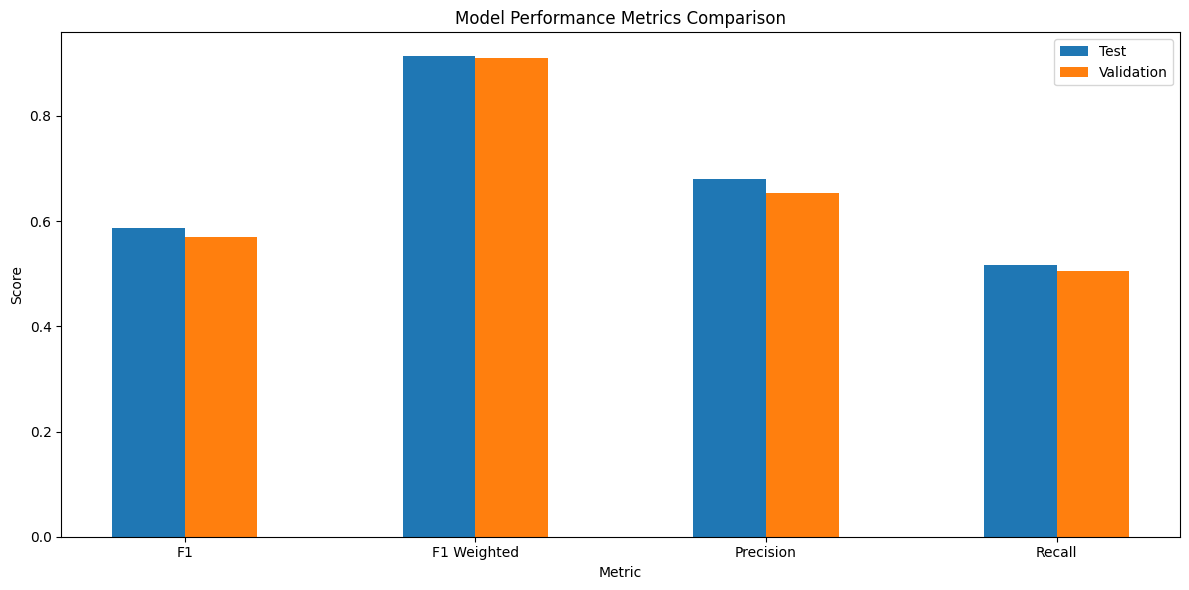

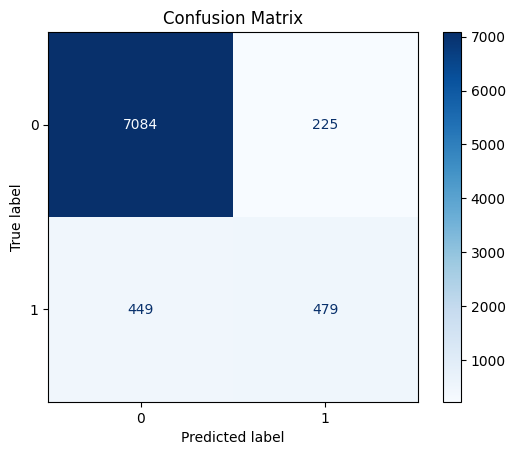

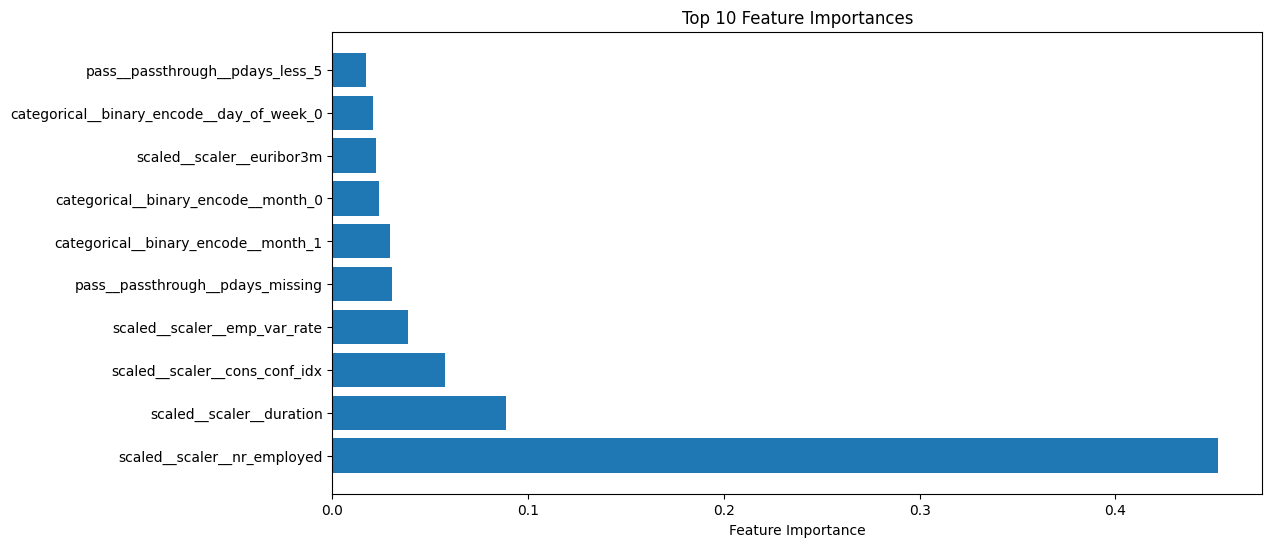

In [3]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV

# Define paths
BASE_PATH = os.path.abspath('..')
PROCESSED_DATA_PATH = os.path.join(BASE_PATH, 'data', 'processed')

# Define file names
X_TRAIN = 'X_train.csv'
Y_TRAIN = 'y_train.csv'
X_TEST = 'X_test.csv'
Y_TEST = 'y_test.csv'
X_VALID = 'X_valid.csv'
Y_VALID = 'y_valid.csv'

# Set random seed for reproducibility
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

# Load the preprocessed data
X_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TRAIN))
y_train = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TRAIN)).values.ravel()
X_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_TEST))
y_test = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_TEST)).values.ravel()
X_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, X_VALID))
y_valid = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, Y_VALID)).values.ravel()




# Define XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=RANDOM_SEED)

# Define the hyperparameter search space
param_space = {
    'max_depth': (3, 10),            # int
    'learning_rate': (0.01, 0.3),    # float
    'n_estimators': (50, 500),       # int
    'min_child_weight': (1, 10),     # int
    'subsample': (0.5, 1.0),         # float
    'colsample_bytree': (0.5, 1.0)   # float
}

# Initialize BayesSearchCV for hyperparameter optimization
opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=30,                      # Number of parameter settings sampled
    scoring='f1_weighted',         # Scoring method
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED),
    n_jobs=-1,                     # Use all available cores
    random_state=RANDOM_SEED
)

# Fit the model using BayesSearchCV
opt.fit(X_train, y_train)

# Get the best parameters
best_params = opt.best_params_
print("Best parameters found: ", best_params)

# Train final model with the best parameters
print("\nTraining final model on the full training dataset...")
xgb_model_final = xgb.XGBClassifier(**best_params)
xgb_model_final.fit(X_train, y_train)

# Predictions on test and validation sets
y_pred_test = xgb_model_final.predict(X_test)
y_pred_valid = xgb_model_final.predict(X_valid)

# Metrics for test and validation sets
test_f1 = f1_score(y_test, y_pred_test, average='binary')
test_f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
test_precision = precision_score(y_test, y_pred_test, average='binary')
test_recall = recall_score(y_test, y_pred_test, average='binary')

valid_f1 = f1_score(y_valid, y_pred_valid, average='binary')
valid_f1_weighted = f1_score(y_valid, y_pred_valid, average='weighted')
valid_precision = precision_score(y_valid, y_pred_valid, average='binary')
valid_recall = recall_score(y_valid, y_pred_valid, average='binary')

# Print metrics summary
print(f"\nTest Set Metrics: F1={test_f1:.4f}, F1 Weighted={test_f1_weighted:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}")
print(f"Validation Set Metrics: F1={valid_f1:.4f}, F1 Weighted={valid_f1_weighted:.4f}, Precision={valid_precision:.4f}, Recall={valid_recall:.4f}")

# Plot Model Performance Metrics Comparison
metrics_data = {
    'Metric': ['F1', 'F1 Weighted', 'Precision', 'Recall'],
    'Test': [test_f1, test_f1_weighted, test_precision, test_recall],
    'Validation': [valid_f1, valid_f1_weighted, valid_precision, valid_recall]
}
metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(4)

plt.bar(index, metrics_df['Test'], bar_width, label='Test')
plt.bar(index + bar_width, metrics_df['Validation'], bar_width, label='Validation')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Metrics Comparison')
plt.xticks(index + bar_width / 2, metrics_df['Metric'])
plt.legend()
plt.tight_layout()
plt.show()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model_final.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Feature Importance Plot
importance = xgb_model_final.feature_importances_
indices = np.argsort(importance)[::-1]

# Top 10 features
top_n = 10
top_features = indices[:top_n]

plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(top_n), importance[top_features], align='center')
plt.yticks(range(top_n), X_train.columns[top_features])
plt.xlabel("Feature Importance")
plt.show()
